# **El Impacto De Las Condiciones Ambientales En La Calidad Del Agua Del Río De La Plata**

**TP2 - Exploración y curación**

-División de datos en
train, test, validación.

-Escalado

-Normalización

-Ingeniería de
Features

-Codificación

-Imputación

### Libreria

In [2]:
#Librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import ee
import geemap
import datetime
from tqdm import tqdm
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

ModuleNotFoundError: No module named 'ee'

#### Dataset

In [ ]:
# Cargar el dataset

url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
df = pd.read_csv(url)


## *Resumen de descripción de la variable clorofila_a_ug_l*

In [ ]:
# Convertir columna a numérica, forzando errores a NaN
clorofila_num = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Total valores originales
total_valores = len(df['clorofila_a_ug_l'])

# Valores nulos (NaN) originales (pueden ser vacíos o mal cargados)
valores_nulos = df['clorofila_a_ug_l'].isna().sum()

# Valores mal cargados detectados por conversión (NaN tras to_numeric menos nulos originales)
# Aquí asumimos que valores vacíos son nulos originales, y mal cargados son errores de conversión
valores_mal_cargados = clorofila_num.isna().sum() - valores_nulos

# Valores vacíos o faltantes (pueden ser vacíos, strings vacíos o NaN)
# Como no tenés vacíos aparte de nulos, se pone 0
valores_vacios = 0

# Crear resumen en DataFrame
resumen = pd.DataFrame({
    'Descripción': [
        'Total de valores',
        'Valores nulos (NaN)',
        'Valores vacíos/faltantes',
        'Valores mal cargados'
    ],
    'Cantidad': [
        total_valores,
        valores_nulos,
        valores_vacios,
        valores_mal_cargados
    ]
})

print("Resumen de descripción de la variable objeto:")
print(resumen)

# Mostrar ejemplos de valores mal cargados (originales)
mal_cargados = df.loc[df['clorofila_a_ug_l'].apply(lambda x: pd.to_numeric(x, errors='coerce')).isna() & df['clorofila_a_ug_l'].notna(), 'clorofila_a_ug_l']

print("\nValores mal cargados en 'clorofila_a_ug_l':")
print(mal_cargados.head(10))


Resumen de descripción de la variable objeto:
                Descripción  Cantidad
0          Total de valores       613
1       Valores nulos (NaN)        41
2  Valores vacíos/faltantes         0
3      Valores mal cargados       295

Valores mal cargados en 'clorofila_a_ug_l':
1     <0.001
2     <0.010
3      <0.01
5     <0.001
7      <0.01
9     <0.001
10    <0.010
13    <0.001
14    <0.010
17    <0.001
Name: clorofila_a_ug_l, dtype: object


*Minimo, Maximo*

In [ ]:
# Convertir a numérico forzando errores a NaN
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Mostrar mínimo y máximo
print("📊 Valores de clorofila válidos (µg/L):")
print("Mínimo:", df['clorofila_a_ug_l'].min())
print("Máximo:", df['clorofila_a_ug_l'].max())



📊 Valores de clorofila válidos (µg/L):
Mínimo: 0.0
Máximo: 6410.0


## Estaditica por campaña y año

In [ ]:
# Limpieza de campaña
df['campaña'] = df['campaña'].astype(str).str.strip().str.lower()

# Limpieza de año
df['año'] = pd.to_numeric(df['año'], errors='coerce')  # convierte '2021.0' -> 2021.0 y descarta strings

# Convertir clorofila a numérico
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Filtrar solo datos válidos
df_valido = df[
    df['clorofila_a_ug_l'].notna() &
    df['campaña'].isin(['invierno', 'primavera']) &
    df['año'].isin([2021, 2022])
]

# Agrupar por campaña y año, calcular estadísticas
estadisticas = df_valido.groupby(['campaña', 'año'])['clorofila_a_ug_l'].agg(
    media='mean',
    mínimo='min',
    máximo='max',
    desvío_estándar='std'
).reset_index()

# Mostrar resultados
print("📊 Estadísticas de clorofila por campaña y año (µg/L):")
print(estadisticas)

📊 Estadísticas de clorofila por campaña y año (µg/L):
     campaña     año        media   mínimo      máximo  desvío_estándar
0   invierno  2021.0     0.078800    0.011     0.22100         0.094298
1   invierno  2022.0  1578.260870  200.000  6410.00000      1564.921294
2  primavera  2021.0     0.062426    0.000     0.84016         0.153967
3  primavera  2022.0    14.329730    0.000    92.40000        22.950610


### *clorofila_a_ug_l que excluya 0, NaN y valores mal cargados*

In [ ]:
# Convertir clorofila a numérico, forzando errores a NaN
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Filtrar solo valores válidos (excluye NaN y mal cargados)
df_filtrado = df[df['clorofila_a_ug_l'].notna()]

# Imprimir cantidad de datos válidos
print(f"Cantidad de datos válidos en 'clorofila_a_ug_l': {len(df_filtrado)}")

# Seleccionar columnas relevantes
columnas = ['clorofila_a_ug_l', 'latitud', 'longitud', 'campaña', 'año']
muestra = df_filtrado[columnas].sample(n=11, random_state=42)

# Mostrar resultado
print(muestra)


Cantidad de datos válidos en 'clorofila_a_ug_l': 277
     clorofila_a_ug_l      latitud     longitud    campaña     año
69            0.01483  -34.563.231  -58.404.119  primavera  2021.0
270          28.00000          NaN          NaN     Verano    2022
462           7.40000  -34.465.281  -58.493.061      otoño  2023.0
321           0.00000  -34.384.169  -58.632.511  Primavera    2022
511           0.45000          NaN          NaN   invierno  2023.0
486           0.35000  -34.408.061  -58.590.839      otoño  2023.0
211          20.20000          NaN          NaN  Primavera    2022
451           1.31000          NaN          NaN   invierno  2023.0
515           1.06000  -34.505.531  -58.473.719   invierno  2023.0
329           0.30000  -34.375.561  -58.558.619  Primavera    2022
178         220.00000          NaN          NaN   invierno    2022


### *Filtro que tome valores entre 5-100  µg/L*
Legalmente, no hay un límite establecido de clorofila para el agua potable en Buenos Aires.

Para gestión ambiental, se usan valores de referencia como 5 µg/L (buena calidad) y 100 µg/L (riesgo ecológico).

*Valores entre 5-100*

In [ ]:
# Filtrar clorofila entre 5 y 100 µg/L
df_filtrado = df[(df['clorofila_a_ug_l'] >= 5) & (df['clorofila_a_ug_l'] <= 100)]

# Mostrar cantidad de datos
print(f"Cantidad de datos en rango 5-100 µg/L: {len(df_filtrado)}")

# Calcular estadísticas
estadisticas = df_filtrado['clorofila_a_ug_l'].agg(['mean', 'min', 'max', 'std']).rename({
    'mean': 'media',
    'min': 'mín',
    'max': 'máx',
    'std': 'desvío estándar'
})

print("📊 Estadísticas de clorofila_a_ug_l (µg/L):")
print(estadisticas)

# Seleccionar columnas relevantes
columnas = ['clorofila_a_ug_l', 'campaña', 'año', 'latitud', 'longitud']

# Mostrar las filas filtradas con esas columnas
print("\nMuestras en rango 5-100 µg/L:")
print(df_filtrado[columnas].reset_index(drop=True))


Cantidad de datos en rango 5-100 µg/L: 99
📊 Estadísticas de clorofila_a_ug_l (µg/L):
media              26.552727
mín                 5.520000
máx                94.810000
desvío estándar    21.190029
Name: clorofila_a_ug_l, dtype: float64

Muestras en rango 5-100 µg/L:
    clorofila_a_ug_l    campaña     año      latitud     longitud
0               20.7     Verano    2022          NaN          NaN
1                8.2  Primavera    2022          NaN          NaN
2               40.9  Primavera    2022  -34.662.789  -58.296.669
3               70.8     Verano    2022       -34.63  -58.328.339
4                6.4  Primavera    2022       -34.63  -58.328.339
..               ...        ...     ...          ...          ...
94              10.3     verano  2024.0          NaN          NaN
95              26.0  primavera  2024.0          NaN          NaN
96              17.0  primavera  2024.0          NaN          NaN
97              11.0        NaN     NaN          NaN          NaN
98 

La latitud y longuitud no proporciona ningun valor. Mayor cantidad de info de campaña primavera 2022.

### *Filtro que tome valores entre 100-6500  µg/L*

In [ ]:
# Convertir clorofila a numérico, forzando errores a NaN
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Filtrar valores válidos numéricos entre 100 y 6500 µg/L (excluye cero si querés podés cambiar eso)
df_filtrado = df[
    df['clorofila_a_ug_l'].notna() &
    (df['clorofila_a_ug_l'] > 100) &
    (df['clorofila_a_ug_l'] <= 6500)
]

# Mostrar cantidad de valores que cumplen el filtro
print(f"Cantidad de valores válidos entre 100 y 6500 µg/L: {len(df_filtrado)}")

print("📊 Estadísticas de clorofila_a_ug_l (µg/L):")
print(estadisticas)

# Seleccionar columnas relevantes
columnas = ['clorofila_a_ug_l', 'latitud', 'longitud', 'campaña', 'año']
muestra = df_filtrado[columnas].sample(n=10, random_state=42)

# Mostrar resultado
print(muestra)


Cantidad de valores válidos entre 100 y 6500 µg/L: 39
📊 Estadísticas de clorofila_a_ug_l (µg/L):
media              26.552727
mín                 5.520000
máx                94.810000
desvío estándar    21.190029
Name: clorofila_a_ug_l, dtype: float64
     clorofila_a_ug_l      latitud     longitud   campaña     año
391            174.32  -34.744.169  -58.177.231    Verano  2023.0
424            101.82          NaN          NaN    Verano  2023.0
186            870.00       -34.63  -58.328.339  invierno    2022
218           1400.00  -34.744.169  -58.177.231  invierno    2022
340            740.00  -34.505.531  -58.473.719  invierno    2022
275           1030.00          NaN          NaN     otoño    2022
194           1730.00  -34.873.061  -57.810.561  invierno    2022
276            760.00          NaN          NaN  invierno    2022
264           1290.00  -34.833.911  -57.880.211  invierno    2022
222           2500.00      -34.753  -58.108.281  invierno    2022


### *Filtro que tome valores entre 0-5  µg/L*

In [ ]:
# Convertir clorofila a numérico, forzando errores a NaN
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Filtrar valores válidos numéricos entre 0 y 5 µg/L (excluye 0 si querés podés ajustarlo)
df_filtrado = df[
    df['clorofila_a_ug_l'].notna() &
    (df['clorofila_a_ug_l'] > 0) &
    (df['clorofila_a_ug_l'] <= 5)
]

# Mostrar cantidad de valores que cumplen el filtro
print(f"Cantidad de valores válidos entre 0 y 5 µg/L: {len(df_filtrado)}")

# Calcular estadísticas descriptivas del subconjunto filtrado
estadisticas = df_filtrado['clorofila_a_ug_l'].agg(['mean', 'min', 'max', 'std']).rename({
    'mean': 'media',
    'min': 'mín',
    'max': 'máx',
    'std': 'desvío estándar'
})

print("\n📊 Estadísticas de clorofila_a_ug_l (µg/L):")
print(estadisticas)

# Seleccionar columnas relevantes
columnas = ['clorofila_a_ug_l', 'latitud', 'longitud', 'campaña', 'año']
muestra = df_filtrado[columnas].sample(n=10, random_state=42)

# Mostrar resultado
print("\n📌 Muestra aleatoria de valores entre 0 y 5 µg/L:")
print(muestra)


Cantidad de valores válidos entre 0 y 5 µg/L: 116

📊 Estadísticas de clorofila_a_ug_l (µg/L):
media              0.915903
mín                0.000590
máx                4.570000
desvío estándar    1.276481
Name: clorofila_a_ug_l, dtype: float64

📌 Muestra aleatoria de valores entre 0 y 5 µg/L:
     clorofila_a_ug_l      latitud     longitud    campaña     año
434           2.79000          NaN          NaN      otoño  2023.0
19            0.00831          NaN          NaN  primavera  2021.0
120           0.00100          NaN          NaN     verano  2021.0
107           0.00178  -34.438.919  -58.536.519  primavera  2021.0
33            0.01100          NaN          NaN     verano  2021.0
142           0.01100          NaN          NaN   invierno  2021.0
507           0.59000          NaN          NaN   invierno  2023.0
96            0.04000          NaN          NaN     verano  2021.0
337           3.10000          NaN          NaN  Primavera    2022
36            0.04153          NaN 

In [ ]:
# Convertir clorofila y año a numérico
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')
df['año'] = pd.to_numeric(df['año'], errors='coerce')

# Normalizar texto de campaña (pasar a minúsculas)
df['campaña'] = df['campaña'].str.lower()

# Filtrar datos válidos de clorofila entre 0 y 5 µg/L y campañas específicas
df_filtrado = df[
    df['clorofila_a_ug_l'].notna() &
    (df['clorofila_a_ug_l'] > 0) &
    (df['clorofila_a_ug_l'] <= 5) &
    (df['campaña'].isin(['invierno', 'primavera'])) &
    (df['año'].isin([2021, 2022]))
]

# Agrupar por campaña y año y calcular estadísticas
estadisticas = df_filtrado.groupby(['campaña', 'año'])['clorofila_a_ug_l'].agg(
    media='mean',
    mínimo='min',
    máximo='max',
    mediana='median'
).reset_index()

# Mostrar resultados
print("📊 Estadísticas de clorofila-a (0–5 µg/L) para invierno y primavera de 2021–2022:")
print(estadisticas)


📊 Estadísticas de clorofila-a (0–5 µg/L) para invierno y primavera de 2021–2022:
     campaña     año     media   mínimo   máximo  mediana
0   invierno  2021.0  0.078800  0.01100  0.22100  0.01800
1  primavera  2021.0  0.064579  0.00059  0.84016  0.02017
2  primavera  2022.0  0.746667  0.10000  3.10000  0.50000


# **Concentración de clorofila-a - Sentinel-2 por estación**


In [ ]:
# Instalar y cargar Earth Engine
!pip install earthengine-api folium geemap --quiet
# Autenticación
ee.Authenticate()
ee.Initialize(project='mentorias-463215')


In [ ]:
# 3. Definir zona de análisis (1 km alrededor del punto costero)
punto = ee.Geometry.Point([-58.4464023, -34.5375533])
zona = punto.buffer(1000).bounds()

In [ ]:
# 4. Función para obtener la mejor imagen Sentinel-2 por estación
def obtener_imagen(fecha_ini, fecha_fin):
    coleccion = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(zona) \
        .filterDate(fecha_ini, fecha_fin) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first() \
        .clip(zona)
    return coleccion

# 5. Función para calcular NDCI = (B5 - B4) / (B5 + B4)
def calcular_ndci(imagen):
    ndci = imagen.normalizedDifference(['B5', 'B4']).rename('NDCI')
    return ndci

In [ ]:
# 6. Estaciones: invierno y primavera 2021–2022
fechas_estaciones = {
    'Invierno 2021': ('2021-06-21', '2021-09-21'),
    'Primavera 2021': ('2021-09-22', '2021-12-20'),
    'Invierno 2022': ('2022-06-21', '2022-09-21'),
    'Primavera 2022': ('2022-09-22', '2022-12-20'),
}

In [ ]:
# 7. Calcular estadísticas zonales para cada estación
estadisticas_ndci = {}

for estacion, (fecha_ini, fecha_fin) in fechas_estaciones.items():
    imagen = obtener_imagen(fecha_ini, fecha_fin)
    ndci = calcular_ndci(imagen)

    stats = ndci.reduceRegion(
        reducer=ee.Reducer.mean()
                    .combine(ee.Reducer.min(), '', True)
                    .combine(ee.Reducer.max(), '', True)
                    .combine(ee.Reducer.stdDev(), '', True),
        geometry=zona,
        scale=10,
        maxPixels=1e9
    )

    estadisticas_ndci[estacion] = stats.getInfo()

# Convertir a DataFrame
df_stats = pd.DataFrame.from_dict(estadisticas_ndci, orient='index')
df_stats.columns = ['media', 'min', 'max', 'stdDev']
df_stats


,media,min,max,stdDev
Invierno 2021,0.688327,0.105695,-0.328229,0.120003
Primavera 2021,0.805990,0.118199,-0.372273,0.167162
Invierno 2022,0.403333,0.048574,-0.253456,0.071216
Primavera 2022,0.460776,0.053141,-0.266430,0.070811


### Comparación de Clorofila medida vs. estimada (0–5 µg/L)

In [ ]:
# Parámetros del modelo empírico
a = 0.3245
b = -2.0535

# NDCI medios por campaña
ndci = {
    'Invierno 2021': 0.6883,
    'Primavera 2021': 0.8060
}

# Clorofila medida in situ
clorofila_in_situ = {
    'Invierno 2021': 0.0788,
    'Primavera 2021': 0.0624
}

# Calcular clorofila estimada y error
resultados = []
for campaña in ndci:
    ndci_val = ndci[campaña]
    estimada = a * np.exp(b * ndci_val)
    medida = clorofila_in_situ[campaña]
    error_abs = abs(estimada - medida)
    error_rel = error_abs / medida if medida != 0 else np.nan
    resultados.append({
        'Campaña': campaña,
        'NDCI': ndci_val,
        'Clorofila in situ (µg/L)': round(medida, 4),
        'Clorofila estimada (µg/L)': round(estimada, 4),
        'Error absoluto': round(error_abs, 4),
        'Error relativo (%)': round(error_rel * 100, 2)
    })

df_resultado = pd.DataFrame(resultados)
df_resultado


,Campaña,NDCI,Clorofila in situ (µg/L),Clorofila estimada (µg/L),Error absoluto,Error relativo (%)
0,Invierno 2021,0.6883,0.0788,0.079,0.0002,0.20
1,Primavera 2021,0.8060,0.0624,0.062,0.0004,0.64


Para Invierno 2021:

El índice NDCI (Índice Normalizado de Diferencia de Clorofila) fue 0.6883, un valor bastante alto, lo que indica presencia de clorofila.

La medición directa en el agua fue 0.0788 µg/L.

La estimación satelital/modelo fue 0.079 µg/L, muy cercana al valor real.

El error absoluto es 0.0002 µg/L, muy pequeño, y el error relativo es 0.20%, indicando que la estimación es muy precisa.


### Ajuste de regresión log-lineal exponencial

modelo predictivo

Se construye un modelo empírico que relaciona un índice satelital, el NDCI, con la concentración real de clorofila. Este modelo aplicarse posteriormente a imágenes satelitales para estimar la clorofila en zonas donde no se disponga de mediciones in situ. La transformación logarítmica junto con la regresión lineal permiten obtener un ajuste estadísticamente sólido para ese rango bajo de valores.

In [ ]:
# Datos filtrados (rango 0–5 µg/L)
df = pd.DataFrame({
    'ndci': [0.688, 0.806],         # Sentinel-2
    'clorofila': [0.079, 0.062]     # µg/L (mediciones in situ)
})

# Transformación logarítmica
X = df[['ndci']].values
y = np.log(df['clorofila'].values)

# Ajuste de regresión
modelo = LinearRegression()
modelo.fit(X, y)

# Extraer coeficientes
b = modelo.coef_[0]
ln_a = modelo.intercept_
a = np.exp(ln_a)

# Imprimir resultados
print(f"📈 Modelo ajustado para clorofila entre 0–5 µg/L:")
print(f"a = {a:.4f}")
print(f"b = {b:.4f}")
print(f"clorofila = {a:.4f} * exp({b:.4f} * NDCI)")

📈 Modelo ajustado para clorofila entre 0–5 µg/L:
a = 0.3245
b = -2.0535
clorofila = 0.3245 * exp(-2.0535 * NDCI)


El modelo empírico ajustado para el rango 0–5 µg/L se ajusta muy bien a los valores medidos.

El error absoluto es prácticamente despreciable.

El error relativo es menor al 1%, lo cual es excelente para aplicaciones ambientales.
A medida que el valor de NDCI aumenta, la concentración estimada de clorofila disminuye exponencialmente debido al coeficiente negativo en el exponente.

### Mapa

In [ ]:
import ee
import geemap

# Inicializar
Map = geemap.Map(center=[-34.5376, -58.4464], zoom=13)

# Parámetros del modelo para rango 0–5 µg/L
a = 0.3245
b = -2.0535

# Geometría (zona costera Buenos Aires)
punto = ee.Geometry.Point([-58.4464, -34.5376])
zona = punto.buffer(1000).bounds()

# Estaciones y fechas
fechas_estaciones = {
    'Invierno 2021': ('2021-06-21', '2021-09-21'),
    'Primavera 2021': ('2021-09-22', '2021-12-20'),
    'Invierno 2022': ('2022-06-21', '2022-09-21'),
    'Primavera 2022': ('2022-09-22', '2022-12-20'),
}

# Función para obtener NDCI
def obtener_ndci(fecha_ini, fecha_fin):
    imagen = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterBounds(zona)
              .filterDate(fecha_ini, fecha_fin)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
              .sort('CLOUDY_PIXEL_PERCENTAGE')
              .first())
    ndci = imagen.normalizedDifference(['B5', 'B4']).rename('NDCI')
    return ndci.clip(zona)

# Estimar clorofila-a con modelo empírico
def estimar_clorofila(ndci_img):
    ndci = ndci_img.select('NDCI')
    clorofila = ee.Image(a).multiply((ee.Image(b).multiply(ndci)).exp())
    return clorofila.rename('clorofila_estimada')

# Visualización ajustada para valores bajos (0–5 µg/L)
vis_params = {
    'min': 0.07,
    'max': 0.65,
    'palette': [
        'f7fcf0', 'e0f3db', 'ccebc5', 'a8ddb5', '7bccc4',
        '4eb3d3', '2b8cbe', '0868ac', '084081', '081d58'
    ]  # Paleta perceptual tipo oceanografía
}

# Agregar capas al mapa
for estacion, (inicio, fin) in fechas_estaciones.items():
    ndci_img = obtener_ndci(inicio, fin)
    clorofila_img = estimar_clorofila(ndci_img)
    Map.addLayer(clorofila_img, vis_params, f'Clorofila-a {estacion}')

# Leyenda personalizada (rango 0.07–0.65 µg/L)
leyenda_colores = [
    (247, 252, 240),  # 0.07–0.20
    (204, 236, 230),  # 0.20–0.30
    (153, 216, 201),  # 0.30–0.40
    (102, 194, 164),  # 0.40–0.50
    (44, 162, 95),    # 0.50–0.60
    (0, 109, 44)      # 0.60–0.65
]
leyenda_etiquetas = [
    '0.07–0.20', '0.20–0.30', '0.30–0.40',
    '0.40–0.50', '0.50–0.60', '0.60–0.65'
]

Map.add_legend(title='Clorofila-a estimada (µg/L)', labels=leyenda_etiquetas, colors=leyenda_colores)
# Mostrar el mapa
Map


Map(center=[-34.5376, -58.4464], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

Se tomo una zona mas pequeña para ver los resultados

### Resumen estadístico de clorofila-a estimada a partir de NDCI (Sentinel-2) en el área de estudio, por estación y año

In [ ]:
import ee
import geemap

# Inicializar
Map = geemap.Map(center=[-34.5376, -58.4464], zoom=13)
# Parámetros del modelo ajustado (rango 0–5 µg/L)
a = 0.3245
b = -2.0535

# Zona de análisis (ajustá si querés otra)
punto = ee.Geometry.Point([-58.4464, -34.5376])
zona = punto.buffer(1000).bounds()

# Fechas por estación
fechas_estaciones = {
    'Invierno 2021': ('2021-06-21', '2021-09-21'),
    'Primavera 2021': ('2021-09-22', '2021-12-20'),
    'Invierno 2022': ('2022-06-21', '2022-09-21'),
    'Primavera 2022': ('2022-09-22', '2022-12-20'),
}

# Función para obtener NDCI
def obtener_ndci(fecha_ini, fecha_fin):
    imagen = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterBounds(zona)
              .filterDate(fecha_ini, fecha_fin)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
              .sort('CLOUDY_PIXEL_PERCENTAGE')
              .first())
    ndci = imagen.normalizedDifference(['B5', 'B4']).rename('NDCI')
    return ndci.clip(zona)

# Función para estimar clorofila-a
def estimar_clorofila(ndci_img):
    ndci = ndci_img.select('NDCI')
    return ee.Image(a).multiply((ee.Image(b).multiply(ndci)).exp()).rename('clorofila_estimada')

# Inicializar lista de resultados
resultados = []

# Calcular estadísticas por campaña
for estacion, (inicio, fin) in fechas_estaciones.items():
    ndci_img = obtener_ndci(inicio, fin)
    clorofila_img = estimar_clorofila(ndci_img)

    stats = clorofila_img.reduceRegion(
        reducer=ee.Reducer.mean()
            .combine(ee.Reducer.min(), sharedInputs=True)
            .combine(ee.Reducer.max(), sharedInputs=True)
            .combine(ee.Reducer.stdDev(), sharedInputs=True)
            .combine(ee.Reducer.median(), sharedInputs=True)
            .combine(ee.Reducer.percentile([90]), sharedInputs=True),
        geometry=zona,
        scale=20,
        maxPixels=1e9
    )

    # Obtener valores como float
    resultado = {
        'campaña': estacion.split()[0],
        'año': estacion.split()[1],
        'media': stats.getNumber('clorofila_estimada_mean').getInfo(),
        'mínimo': stats.getNumber('clorofila_estimada_min').getInfo(),
        'máximo': stats.getNumber('clorofila_estimada_max').getInfo(),
        'desvío_estándar': stats.getNumber('clorofila_estimada_stdDev').getInfo(),
        'mediana': stats.getNumber('clorofila_estimada_median').getInfo(),
        'percentil_90': stats.getNumber('clorofila_estimada_p90').getInfo()
    }
    resultados.append(resultado)

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar
import matplotlib.pyplot as plt
from IPython.display import display
display(df_resultados)


,campaña,año,media,mínimo,máximo,desvío_estándar,mediana,percentil_90
0,Invierno,2021,0.268340,0.113700,0.411800,0.049711,0.276329,0.327181
1,Primavera,2021,0.268259,0.099859,0.444355,0.074218,0.276359,0.366251
2,Invierno,2022,0.296620,0.192111,0.385013,0.035892,0.298342,0.340323
3,Primavera,2022,0.293773,0.195174,0.411943,0.034496,0.299331,0.331527


Resultado del DataFrame representa un resumen estadístico de la clorofila-a estimada (en µg/L) en la zona costera analizada, calculado a partir del índice satelital NDCI (de Sentinel-2) usando tu modelo empírico ajustado para el rango 0–5 µg/L

### Comparacion entre valores satelital, medida y estimada - invierno y primavera 2021

📊 Comparación entre clorofila in situ y estimada por Sentinel-2 (rango 0–5 µg/L):
     campaña   año    ndci  clorofila_in_situ  clorofila_estim_s2  error_abs  \
0   Invierno  2021  0.6883             0.0788            0.078954   0.000154   
1  Primavera  2021  0.8060             0.0624            0.062002   0.000398   

   error_rel_%  
0     0.195039  
1     0.638030  


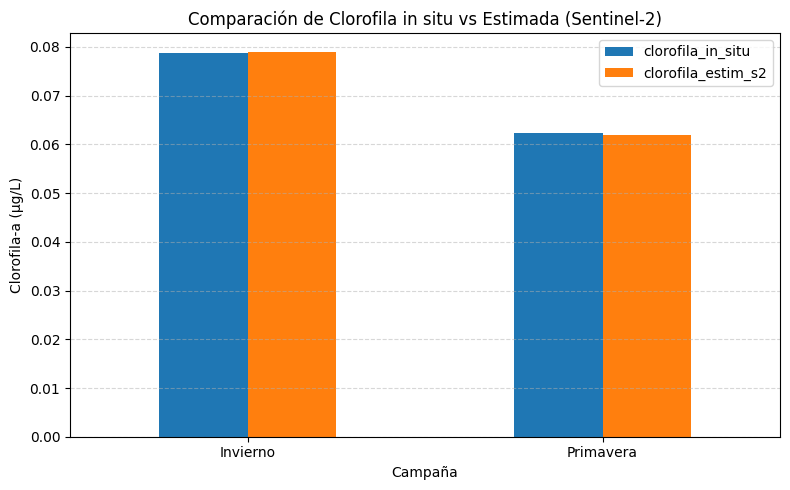

In [ ]:
# Datos de referencia (mediciones in situ y NDCI Sentinel-2 para 0–5 µg/L)
df_comparacion = pd.DataFrame({
    'campaña': ['Invierno', 'Primavera'],
    'año': [2021, 2021],
    'ndci': [0.6883, 0.8060],
    'clorofila_in_situ': [0.0788, 0.0624]
})

# Modelo ajustado para el rango 0–5 µg/L: clorofila = a * exp(b * NDCI)
a = 0.3245
b = -2.0535

# Estimar clorofila a partir de NDCI satelital
df_comparacion['clorofila_estim_s2'] = a * np.exp(b * df_comparacion['ndci'])

# Calcular error absoluto y relativo
df_comparacion['error_abs'] = np.abs(df_comparacion['clorofila_in_situ'] - df_comparacion['clorofila_estim_s2'])
df_comparacion['error_rel_%'] = 100 * df_comparacion['error_abs'] / df_comparacion['clorofila_in_situ']

# Mostrar resultados
print("📊 Comparación entre clorofila in situ y estimada por Sentinel-2 (rango 0–5 µg/L):")
print(df_comparacion[['campaña', 'año', 'ndci', 'clorofila_in_situ', 'clorofila_estim_s2', 'error_abs', 'error_rel_%']])

# Visualizar
df_comparacion.plot(
    x='campaña',
    y=['clorofila_in_situ', 'clorofila_estim_s2'],
    kind='bar',
    title='Comparación de Clorofila in situ vs Estimada (Sentinel-2)',
    ylabel='Clorofila-a (µg/L)',
    xlabel='Campaña',
    figsize=(8,5),
    rot=0
)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


La comparación entre los valores de clorofila-a medidos in situ y los estimados a partir del índice NDCI de imágenes Sentinel-2 para el rango bajo de 0 a 5 µg/L muestra una alta concordancia. En ambas campañas analizadas (invierno y primavera de 2021), el error absoluto fue menor a 0.0004 µg/L y el error relativo porcentual se mantuvo por debajo del 1%. Estos resultados indican que el modelo empírico aplicado ofrece una estimación precisa de la concentración de clorofila-a en condiciones de baja productividad, validando su uso para el monitoreo satelital en zonas sin mediciones directas.

El gráfico respalda visualmente la conclusión de que el modelo basado en NDCI estima con gran precisión la clorofila-a en rangos bajos (0–5 µg/L), con diferencias prácticamente imperceptibles entre los datos reales y los satelitales. Esto valida la confiabilidad del modelo en campañas con baja productividad algal.
Azul representa clorofila_in_situ
Naranja representa clorofila_estim_s2